In [96]:
import numpy as np

In [97]:
timetable_constraints = {
  "nbr_of_days": 5,
  "nbr_of_periods_per_day": 4,
  "nbr_of_subjects": 3,
  "nbr_of_groups": 3,
  "periods_by_subject": [4, 6, 6],
  "subject_names": ["Maths", "Français", "Anglais"],
  "group_names": ["Groupe 1", "Groupe 2", "Group 3"],
  "preferences":{
    "total_count": 15,
    "morning_classes": [0],
  }
}

In [98]:
class Timetable:
  def __init__(self, npArray, constraints):
    self.constraints = constraints
    # timetable as a 3d array ( group, day, period) => subject from npArray
    self.timetable = npArray.reshape(
      (constraints["nbr_of_groups"], constraints["nbr_of_days"], constraints["nbr_of_periods_per_day"])
    )
    pass

  def toNpArray(self):
    return self.timetable.flatten()

  def isValid(self):
    pass

  def fitness(self):
    # return 1 if it is a valid timetable
    # return 0 if it is totally not
    # return a value between 0 and 0.8 if it is partially valid
    # a valid timetable is a timetable that respects all the constraints
    # a partially valid timetable is a timetable that respects some of the constraints
    # a totally invalid timetable is a timetable that respects none of the constraints
    # the value returned is the percentage of constraints that are respected

    respected_constraints = 0
    total_constraints = 0

    for group in self.timetable:
      subject_periods_in_table = np.zeros(self.constraints["nbr_of_subjects"])
      for day in group :
        for period in day:
          if period == -1: continue
          subject_periods_in_table[period]+=1
      respected_constraints += np.sum(subject_periods_in_table == self.constraints["periods_by_subject"])
      total_constraints += self.constraints["nbr_of_subjects"]
      
    score = 0.3*respected_constraints/total_constraints if respected_constraints < total_constraints else 0.8

    bonus = 0
    # check if the morning classes constraint is respected
    for group in self.timetable:
      for day in group:
        for period in day:
          if period == -1: continue
          if period in self.constraints["preferences"]["morning_classes"] and (day[0] == period or day[1] == period):
            bonus += 1
            break

    score += (0.2 if respected_constraints == total_constraints else 0.01) * bonus / self.constraints["preferences"]["total_count"]

    return score + 0.0000000000001

  def plot(self):
    pass

  def print(self):
    print(self.fitness())
    i=0
    for group in self.timetable:
      i+=1
      print("Group : "+str(i))
      print(group)

In [99]:
import pygad

In [100]:
def fitness_func(ga_instance, solution, solution_idx):
    timeTable = Timetable(solution, timetable_constraints)
    fitness = timeTable.fitness()
    return fitness

In [101]:
fitness_function = fitness_func

num_generations = 2000
num_parents_mating = 50

sol_per_pop = 200
gene_space = [ 
              { 
                "low" : -1, 
                "high": timetable_constraints["nbr_of_subjects"],
                "step": 1
              } 
              for _ in range(timetable_constraints["nbr_of_groups"] * timetable_constraints["nbr_of_days"] * timetable_constraints["nbr_of_periods_per_day"])
             ]
num_genes = timetable_constraints["nbr_of_days"] * timetable_constraints["nbr_of_periods_per_day"] * timetable_constraints["nbr_of_groups"]
gene_type = [int for _ in range(num_genes)]

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

Fitness=0.9600	: 100%|████████████████████| 2000/2000 [02:26<00:00, 13.67it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Fitness of the best solution : 0.9600000000001001


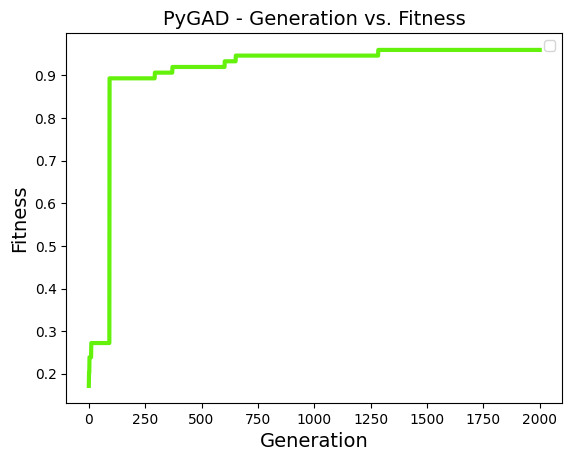

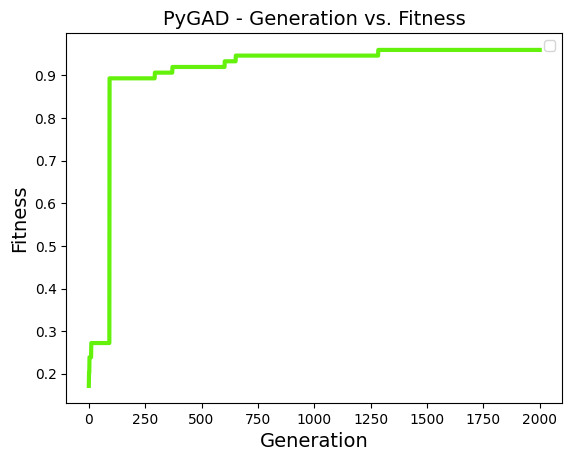

In [102]:
from tqdm import tqdm
progress_bar = tqdm(total=num_generations, bar_format='{l_bar}{bar:20}{r_bar}{bar:-10b}')

def on_gen(ga_instance):
    progress_bar.update(1)
    progress_bar.set_description_str("Fitness={fitness:.4f}\t".format(fitness=ga_instance.best_solution()[1]))
    # print("Fitness of the best solution :", ga_instance.best_solution()[1])

def on_stop(ga_instance, last_generation_fitness):
    progress_bar.close()
    print("Fitness of the best solution :", ga_instance.best_solution()[1])

ga_instance = pygad.GA(num_generations=num_generations,
                       on_generation=on_gen,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       gene_space=gene_space,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                      #  mutation_probability=[0.5, 0.1],
                       gene_type=gene_type,
                       num_genes=num_genes,
                       on_stop=on_stop
                      )

ga_instance.run()
ga_instance.plot_fitness()

In [103]:
progress_bar.close()

In [104]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [2 0 1 2 2 0 -1 1 1 2 2 1 0 1 -1 1 -1 0 -1 2 -1 2 1 1 -1 0 2 2 0 2 1 -1 0
 1 1 1 0 2 2 -1 2 0 -1 2 1 0 2 -1 0 1 1 1 -1 1 -1 2 2 0 2 1]
Fitness value of the best solution = 0.9600000000001001


In [105]:
timetable = Timetable(solution, timetable_constraints)

In [111]:
table = timetable.timetable
table = [[["-" if period == -1 else timetable_constraints["subject_names"][period] for period in day] for day in group] for group in table]

import pandas as pd
table_pd = pd.DataFrame(table[2])
# add day and period columns
table_pd.insert(0, "Day", ["Day "+str(i) for i in range(1, timetable_constraints["nbr_of_days"]+1)])
#rotate the table
table_pd = table_pd.transpose()
table_pd

,0,1,2,3,4
Day,Day 1,Day 2,Day 3,Day 4,Day 5
0,Anglais,Français,Maths,-,Anglais
1,Maths,Maths,Français,Français,Maths
2,-,Anglais,Français,-,Anglais
3,Anglais,-,Français,Anglais,Français
